# Experiment 2: System Prompt Ablation Studies

**Goal:** Identify which components of system prompts carry the most causal weight.

**Setup:**
- Fixed test prompts
- Take complex system prompts and systematically remove components
- Measure impact of each component removal

**Key Questions:**
- Which parts of system prompts matter most?
- Are some components redundant?
- What's the minimal effective system prompt?

In [3]:
# Setup path for imports
import sys
import os

# Handle both local and Colab environments
if 'google.colab' in sys.modules:
    # In Colab - go to repo root
    repo_root = '/content/LLM-Instruction-Understanding'
    if os.path.exists(repo_root):
        os.chdir(repo_root)
        if repo_root not in sys.path:
            sys.path.insert(0, repo_root)
else:
    # Local - add parent directory
    parent = os.path.abspath('..')
    if parent not in sys.path:
        sys.path.insert(0, parent)

print(f"Working directory: {os.getcwd()}")

Working directory: /content/LLM-Instruction-Understanding


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from src.model_utils import load_model
from src.metrics import DistributionMetrics
from src.visualization import set_style
from src.test_configs import (
    TEST_PROMPTS, ALL_TEST_PROMPTS, SYSTEM_PROMPTS,
    build_chat_prompt, get_all_categories
)

set_style()

In [5]:
model = load_model("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

Loading model: TinyLlama/TinyLlama-1.1B-Chat-v1.0


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Model loaded on cuda


## 1. Define Component-Based System Prompts

In [6]:
# A complex system prompt broken into components
COMPONENTS = {
    "role": "You are a helpful AI assistant.",
    "expertise": "You have expertise across many domains.",
    "accuracy": "Always provide accurate information.",
    "honesty": "Be honest about uncertainty.",
    "reasoning": "Think step by step before answering.",
    "format": "Be clear and concise in your responses.",
    "safety": "Avoid harmful or misleading content.",
}

def build_system_prompt(include_components):
    """Build system prompt from selected components."""
    parts = [COMPONENTS[c] for c in include_components if c in COMPONENTS]
    return " ".join(parts)

# Full system prompt with all components
FULL_SYSTEM = build_system_prompt(COMPONENTS.keys())
print(f"Full system prompt ({len(COMPONENTS)} components):\n{FULL_SYSTEM}")

Full system prompt (7 components):
You are a helpful AI assistant. You have expertise across many domains. Always provide accurate information. Be honest about uncertainty. Think step by step before answering. Be clear and concise in your responses. Avoid harmful or misleading content.


## 2. Single Component Ablation

In [7]:
def run_ablation_experiment(model, test_prompts, components, n_test=10):
    """Run ablation: measure effect of removing each component."""
    test_subset = test_prompts[:n_test]
    
    # Get baseline (full system prompt)
    full_prompt = build_system_prompt(components.keys())
    baseline_results = []
    
    for test in test_subset:
        prompt = build_chat_prompt(full_prompt, test["prompt"], model.tokenizer)
        dist = model.get_next_token_distribution(prompt, top_k=50)
        baseline_results.append({
            "test_id": test["id"],
            "full_probs": dist["full_probs"],
            "entropy": dist["entropy"],
            "top_token": dist["top_tokens"][0]
        })
    
    # Ablate each component
    ablation_results = []
    
    for remove_component in tqdm(components.keys(), desc="Ablating components"):
        # Build system prompt without this component
        remaining = [c for c in components.keys() if c != remove_component]
        ablated_prompt = build_system_prompt(remaining)
        
        for i, test in enumerate(test_subset):
            prompt = build_chat_prompt(ablated_prompt, test["prompt"], model.tokenizer)
            dist = model.get_next_token_distribution(prompt, top_k=50)
            
            # Compare to baseline
            js = DistributionMetrics.jensen_shannon(
                baseline_results[i]["full_probs"], dist["full_probs"]
            )
            
            ablation_results.append({
                "removed_component": remove_component,
                "test_id": test["id"],
                "js_divergence": js,
                "entropy_change": dist["entropy"] - baseline_results[i]["entropy"],
                "top_token_changed": dist["top_tokens"][0] != baseline_results[i]["top_token"]
            })
    
    return pd.DataFrame(ablation_results)

In [8]:
ablation_df = run_ablation_experiment(model, ALL_TEST_PROMPTS, COMPONENTS, n_test=15)

# Aggregate by component
component_impact = ablation_df.groupby('removed_component').agg({
    'js_divergence': ['mean', 'std'],
    'entropy_change': 'mean',
    'top_token_changed': 'mean'
}).round(4)
component_impact.columns = ['js_mean', 'js_std', 'entropy_change', 'top_change_rate']
component_impact = component_impact.sort_values('js_mean', ascending=False)

print("=== Component Impact (removal effect) ===")
print("Higher JS = component has MORE impact")
print(component_impact)

Ablating components:   0%|          | 0/7 [00:00<?, ?it/s]

=== Component Impact (removal effect) ===
Higher JS = component has MORE impact
                   js_mean  js_std  entropy_change  top_change_rate
removed_component                                                  
accuracy               inf     NaN             NaN           1.0000
expertise              inf     NaN             NaN           1.0000
format                 inf     NaN             NaN           1.0000
honesty                inf     NaN             NaN           0.9333
reasoning              inf     NaN             NaN           1.0000
role                   inf     NaN             NaN           1.0000
safety                 inf     NaN             NaN           1.0000


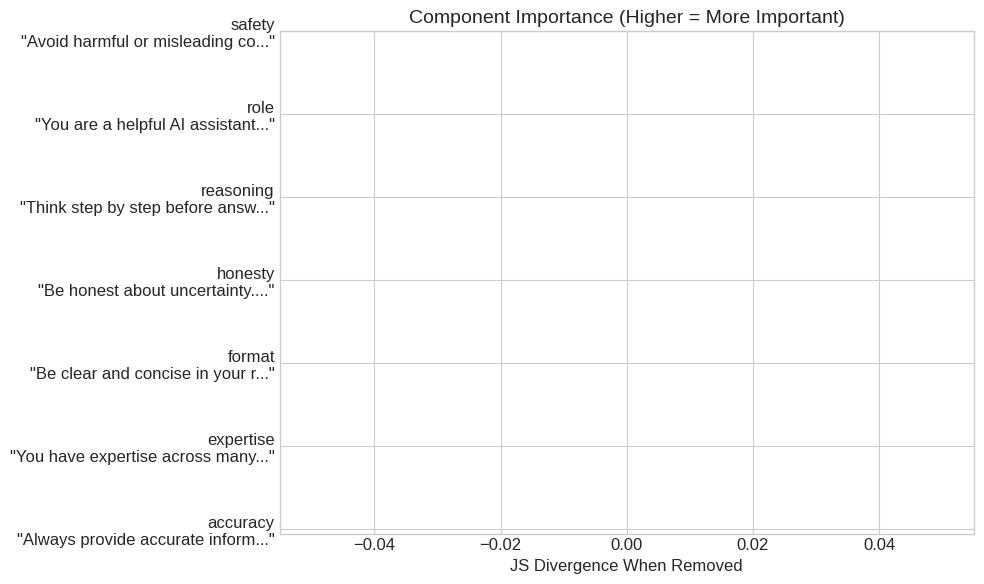

In [9]:
import os
os.makedirs('../results', exist_ok=True)

fig, ax = plt.subplots(figsize=(10, 6))

c = component_impact.sort_values('js_mean')
colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(c)))
ax.barh(range(len(c)), c['js_mean'], xerr=c['js_std'], color=colors, capsize=3)
ax.set_yticks(range(len(c)))
ax.set_yticklabels([f"{idx}\n\"{COMPONENTS[idx][:30]}...\"" for idx in c.index])
ax.set_xlabel('JS Divergence When Removed')
ax.set_title('Component Importance (Higher = More Important)')

plt.tight_layout()
plt.savefig('../results/exp2_component_importance.png', dpi=150)
plt.show()

## 3. Cumulative Ablation (Remove Multiple)

In [10]:
def cumulative_ablation(model, test_prompts, components, order, n_test=10):
    """Remove components one by one in specified order."""
    test_subset = test_prompts[:n_test]
    all_components = list(components.keys())
    
    # Baseline: no system prompt
    no_system_results = []
    for test in test_subset:
        prompt = build_chat_prompt("", test["prompt"], model.tokenizer)
        dist = model.get_next_token_distribution(prompt, top_k=50)
        no_system_results.append(dist["entropy"])
    
    results = [{"n_components": 0, "components": "none", "mean_entropy": np.mean(no_system_results)}]
    
    # Add components one by one
    current_components = []
    for comp in order:
        current_components.append(comp)
        sys_prompt = build_system_prompt(current_components)
        
        entropies = []
        for test in test_subset:
            prompt = build_chat_prompt(sys_prompt, test["prompt"], model.tokenizer)
            dist = model.get_next_token_distribution(prompt, top_k=50)
            entropies.append(dist["entropy"])
        
        results.append({
            "n_components": len(current_components),
            "components": "+".join(current_components),
            "last_added": comp,
            "mean_entropy": np.mean(entropies)
        })
    
    return pd.DataFrame(results)

In [11]:
# Try different orderings
# Order by importance (most important first)
importance_order = component_impact.index.tolist()

cumulative_df = cumulative_ablation(model, ALL_TEST_PROMPTS, COMPONENTS, importance_order, n_test=10)
print(cumulative_df)

   n_components                                         components  \
0             0                                               none   
1             1                                           accuracy   
2             2                                 accuracy+expertise   
3             3                          accuracy+expertise+format   
4             4                  accuracy+expertise+format+honesty   
5             5        accuracy+expertise+format+honesty+reasoning   
6             6   accuracy+expertise+format+honesty+reasoning+role   
7             7  accuracy+expertise+format+honesty+reasoning+ro...   

   mean_entropy last_added  
0           NaN        NaN  
1           NaN   accuracy  
2           NaN  expertise  
3           NaN     format  
4           NaN    honesty  
5           NaN  reasoning  
6           NaN       role  
7           NaN     safety  


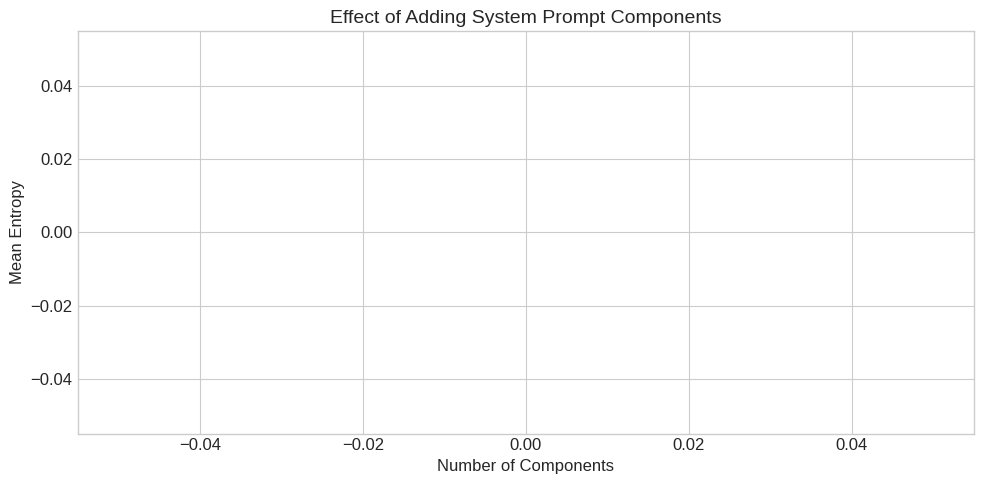

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(cumulative_df['n_components'], cumulative_df['mean_entropy'], 'o-', linewidth=2, markersize=8)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Mean Entropy')
ax.set_title('Effect of Adding System Prompt Components')

# Annotate
for i, row in cumulative_df.iterrows():
    if i > 0:
        ax.annotate(row.get('last_added', ''), (row['n_components'], row['mean_entropy']),
                   textcoords="offset points", xytext=(5, 5), fontsize=8)

plt.tight_layout()
plt.savefig('../results/exp2_cumulative.png', dpi=150)
plt.show()

## 4. Surface-Level Modifications

In [13]:
# Test if surface changes to system prompt matter
SURFACE_VARIANTS = {
    "original": FULL_SYSTEM,
    "lowercase": FULL_SYSTEM.lower(),
    "uppercase": FULL_SYSTEM.upper(),
    "no_periods": FULL_SYSTEM.replace(".", ""),
    "extra_spaces": FULL_SYSTEM.replace(" ", "  "),
    "newlines": FULL_SYSTEM.replace(". ", ".\n"),
}

In [14]:
surface_results = []
test_subset = ALL_TEST_PROMPTS[:10]

# Get original baseline
original_dists = []
for test in test_subset:
    prompt = build_chat_prompt(SURFACE_VARIANTS["original"], test["prompt"], model.tokenizer)
    dist = model.get_next_token_distribution(prompt, top_k=50)
    original_dists.append(dist)

# Compare variants
for variant_name, variant_text in tqdm(SURFACE_VARIANTS.items()):
    if variant_name == "original":
        continue
    
    for i, test in enumerate(test_subset):
        prompt = build_chat_prompt(variant_text, test["prompt"], model.tokenizer)
        dist = model.get_next_token_distribution(prompt, top_k=50)
        
        js = DistributionMetrics.jensen_shannon(original_dists[i]["full_probs"], dist["full_probs"])
        
        surface_results.append({
            "variant": variant_name,
            "test_id": test["id"],
            "js_divergence": js
        })

surface_df = pd.DataFrame(surface_results)
surface_impact = surface_df.groupby('variant')['js_divergence'].agg(['mean', 'std']).round(4)
print("=== Surface Modification Impact ===")
print(surface_impact.sort_values('mean', ascending=False))

  0%|          | 0/6 [00:00<?, ?it/s]

=== Surface Modification Impact ===
              mean  std
variant                
extra_spaces   inf  NaN
lowercase      inf  NaN
newlines       inf  NaN
no_periods     inf  NaN
uppercase      inf  NaN


## 5. Key Findings

In [15]:
print("="*60)
print("EXPERIMENT 2 SUMMARY: System Prompt Ablation")
print("="*60)

print("\n1. MOST IMPORTANT Components (removing hurts most):")
for comp in component_impact.head(3).index:
    print(f"   • {comp}: {COMPONENTS[comp][:50]}...")

print("\n2. LEAST IMPORTANT Components:")
for comp in component_impact.tail(3).index:
    print(f"   • {comp}: {COMPONENTS[comp][:50]}...")

print("\n3. Surface Modifications Matter?")
if surface_impact['mean'].max() > 0.1:
    print("   → Yes, formatting affects output")
else:
    print("   → No, model is robust to surface changes")

EXPERIMENT 2 SUMMARY: System Prompt Ablation

1. MOST IMPORTANT Components (removing hurts most):
   • accuracy: Always provide accurate information....
   • expertise: You have expertise across many domains....
   • format: Be clear and concise in your responses....

2. LEAST IMPORTANT Components:
   • reasoning: Think step by step before answering....
   • role: You are a helpful AI assistant....
   • safety: Avoid harmful or misleading content....

3. Surface Modifications Matter?
   → Yes, formatting affects output


In [16]:
import json
with open('../results/exp2_results.json', 'w') as f:
    json.dump({
        "component_impact": component_impact.to_dict(),
        "surface_impact": surface_impact.to_dict()
    }, f, indent=2, default=float)
print("Saved.")

Saved.
